In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_
from sqlalchemy import distinct

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [58]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


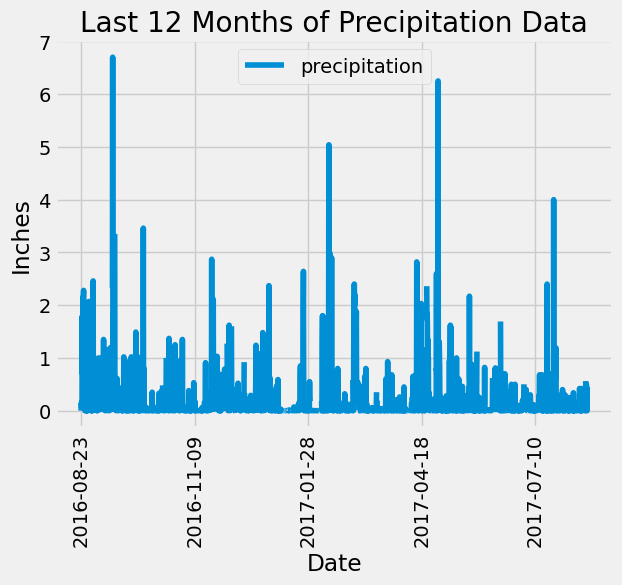

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_datetime = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_datetime - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
last_12_months_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_12_months_precip, columns=['date', 'precipitation'])
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Last 12 Months of Precipitation Data")
plt.show()



In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data = session.query(Measurement.date, Measurement.prcp).all()
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
precip_df.set_index('date', inplace=True)
summary_stats = precip_df.describe().round(2)

print(summary_stats)

       precipitation
count       18103.00
mean            0.16
std             0.47
min             0.00
25%             0.00
50%             0.01
75%             0.11
max            11.53


# Exploratory Station Analysis

In [60]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(distinct(Measurement.station))).scalar()
print(f'Total stations: {total_stations}')

Total stations: 9


In [61]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations_df = pd.DataFrame(most_active_stations, columns=['Station', 'Count'])
print(most_active_stations_df)

       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]


temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

temp_data_df = pd.DataFrame(temp_data, columns=['Lowest Temp', 'Highest Temp', 'Average Temp']).round(0)
print(temp_data_df)

   Lowest Temp  Highest Temp  Average Temp
0         54.0          85.0          72.0


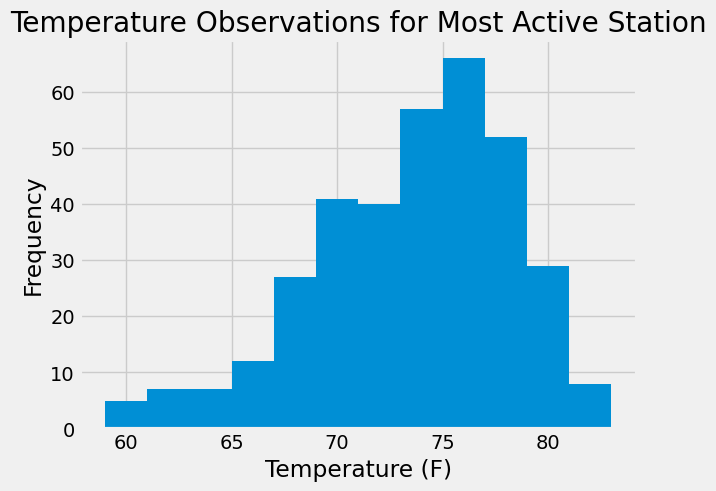

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
temp_data = session.query(Measurement.tobs).filter(and_(Measurement.station == most_active_station, Measurement.date >= one_year_ago)).all()
temp_data_df = pd.DataFrame(temp_data, columns=['temperature'])
plt.hist(temp_data_df['temperature'], bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station')
plt.show()


# Close session

In [64]:
# Close Session
session.close()